In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from cea_post import Read_datset

# Initial State Requierment (燃焼初期の要求)

In [2]:
# calculation property
m0 = 50 # initial total mass [kg]
Ll = 5.2 # launcher length [m]
vc = 30.5 # required launch clear velocity [m/s]
g = 9.8 # acceleration of gravity [m/s^2]

In [3]:
# calculation
Freq = m0*g + m0*np.power(vc,2)/(2*Ll) # initial required thrust [N]
tc = 2*Ll/vc # launch claer time [s]

**assigned value**  
* Inital toal mass: $m_0$ = {{m0}} kg
* Launcher length: $L_l$ = {{Ll}} m
* Required launch clear velocity: $v_c$ = {{vc}} m/s

**calcualted value**  
Initial required thrust (必要初期推力):  
* $F_{req}$ = {{round(Freq,0)}} N  

Launch clear time (ランチクリア時間):   
* $t_c$ = {{round(tc,3)}} s

# Final Pressure of tank (燃焼終了時のタンク圧力)  
※　酸化剤タンク圧力と気蓄器タンク圧力は等しいとする

In [4]:
# calculation property
gamma_g = 1.4 # specific heat ratio of pressurizing gas
Vg = 3.4e-3 # gas tank volume [m^3]
Vt = 10.0e-3 # liuid oxidizer tank volume [m^3]
Pgi = 10.0e+6 # initial gas tank pressure [MPa]

In [5]:
# calculation part
Ptf = Pgi*np.power(Vg/(Vg+Vt), gamma_g)

**assigned value**
* Specific heat ratio of gas: $\gamma_g$ = {{gamma_g}}
* Gas tank volume: $V_g$ = {{Vg*1.0e+3}} L
* Oxidizer tank volume $V_t$ = {{Vt*1.0e+3}} L
* Intial gas tank pressure = $P_{g,i}$ = {{Pgi*1.0e-6}} MPa

**calculated value**  
Final pressure of tank (燃焼終了時タンク圧力):  
* $P_{t,f}$ = {{round(Ptf*1.0e-6,3)}} MPa

# Required initial oxidizer mass flow rate (必要初期酸化剤流量)

In [6]:
# calculation property
cea_fldpath = os.path.join("cea_db", "LOX_PE","csv_database")
read_cea = Read_datset(cea_fldpath)
func_cstr = read_cea.gen_func("CSTAR")
func_gamma = read_cea.gen_func("GAMMAs_c")
eta = 0.7 # c* efficiency
Pci = 3.0e+6 # initial chamber pressure [MPa]
Pei = 0.1013e+6 # initial nozzle exit pressure [MPa]. in this case, the value is eqaualt to atmospheric pressure; 1 atm.
ofi = 4.0 # initial O/F

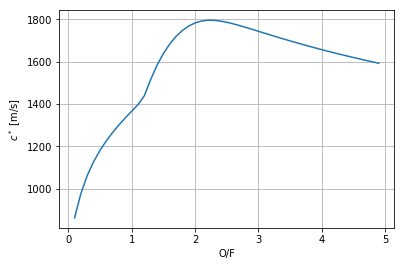

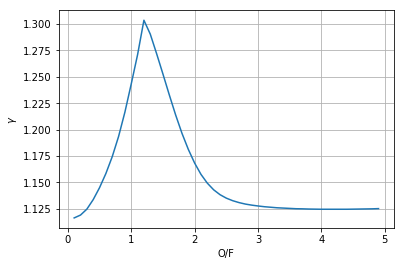

In [7]:
%matplotlib inline
of_plotrange = np.arange(0.1, 5.0, 0.1)
plt.plot(of_plotrange, np.array([func_cstr(of, Pci)  for of in of_plotrange]))
plt.grid()
plt.xlabel("O/F")
plt.ylabel("$c^*$ [m/s]")
plt.show()
plt.plot(of_plotrange, np.array([func_gamma(of, Pci)  for of in of_plotrange]))
plt.grid()
plt.ylabel("$\gamma$")
plt.xlabel("O/F")
plt.show()

In [8]:
# calcualtion part
gamma_i = func_gamma(ofi, Pci)
cstr_i = func_cstr(ofi, Pci)
CFi = np.sqrt(2*np.power(gamma_i,2)/(gamma_i-1) *np.power(2/(gamma_i+1), (gamma_i+1)/(gamma_i-1)) *(1-np.power(Pei/Pci, (gamma_i-1)/gamma_i))) # thrust coefficient
mp_req = Freq/(CFi*eta*cstr_i)
mox_req = (ofi/(1+ofi))*mp_req

**assigned value**  
* $P_{c,i}$ = {{Pci*1.e-6}} MPa  
* $P_{e,i}$ = {{Pei* 1.e-6}} MPa  
* $O/F_i$ = {{ofi}}
* $\eta_{c^*}$ = {{eta}}



**calculated value**  
$\gamma_i$ = {{gamma_i}}   
$c^*_i$ = {{cstr_i}} m/s  
$C_{F,i}$ = {{CFi}}  
$\dot m_{p,req}$ = {{mp_req}} kg/s  

**Required initial oxidizer mass flow rate (必要初期酸化剤流量)**:  
* $\dot m_{ox,req}$ = {{mox_req}} kg/s

# Determin the number of injector port and Cv  (必要なインジェクタポート数とCv値の推定)

In [9]:
# calculation property
Cd = 0.6 # discharge coefficient
D_inj = 1.0e-3 # injector port diameter [m]
rho_ox = 1190 # oxidizer density [kg/m^3]
Pti = Pgi # intial oxidizer tank pressure [Pa]. In this case, the value is equal to initial gas tank pressure

In [10]:
# calcuration part
N_req = 4*mox_req/(np.power(D_inj,2)*np.pi*Cd*np.sqrt(2*rho_ox*(Pti-Pci)))
Cv = mox_req/np.sqrt(2*rho_ox*(Pti-Pci))

**assigned value**  
* $C_d$ = 0.6
* $D_{inj}$ = {{D_inj*1.0e+3}} mm
* $\rho_{ox}$ = {{rho_ox}} kg/m$^3$

**calculated value**  
Required the number of injector port (必要なインジェクタポート数):  
* $N_{req}$ = {{N_req}} 個  

Cv値  
* $C_{v,req}$ = {{Cv}}

# Determin the diameter of nozzle throat (必要ノズルスロート径の推定)

In [11]:
# calculation property
N_inj = 38 # the number of injecotr port
Cv = N_inj*Cd*np.pi*np.power(D_inj,2)/4 # Cv; mass flow rate coefficeint

In [12]:
# calculatioin part
mox_i = Cv*np.sqrt(2*rho_ox*(Pti-Pci))
mp_i = mox_i*(1+1/ofi)
Fi_tmp = CFi*eta*cstr_i*mp_i
Dti = np.sqrt(4*eta*mp_i*cstr_i/(np.pi*Pci))

**assigned value**  
the number of injector port: 
* $N_{inj}$ = {{N_inj}} 個  

coefficient of oxidizer mass flow rate:  
* $C_v$ = {{Cv}}  

**calculated value**  
Initial oxidizer mass flow rate  
* $m_{ox,i}$ = {{mox_i}} kg/s  

Initial propelant mass flow rate  
* $m_{p,i}$ = {{mp_i}} kg/s  

Initial thrust (temporal) 
* $F_{i,tmp}$ = {{Fi_tmp}} N  

Nozzle throat diamter  
* $D_{t,i}$ = {{Dti*1.0e+3}} mm

# Fuel length, port diameter and the number of port (燃料長さと燃料ポート径，ポート数の推定)

## 採用する燃料後退速度式の決定

### 後退速度式の係数に関する単位変換　($\dot r$ : mm/s → m/s,  $G_{ox}$ : g/cm$^2$-s → kg/m$^2$-s)

In [13]:
# coefficient, a, written in mm/s and g/cm^2-s unit
a_org = 0.488
n = 0.62
a = a_org*np.power(10, -(n+3))
print("a={}".format(a))

a=0.0001170630464481511


### 各係数の指定

In [14]:
a = 1.17063e-4 # coefficient of oxidizer mass flux
n = 0.62 # exponential factor of oxidizer mass flux

## 各ポート数に対する，必要な燃料長さとポート径

In [15]:
# calculation property
rho_f = 820 # fuel density [kg/m^3]

def Lf_req(Np, Df):
    Gox = func_Gox(Np, Df)
    r = func_r(Gox)
    Lf = (mox_i/ofi)/(Np*np.pi*Df*rho_f*r)
    return(Lf)

def func_Gox(Np, Df):
    Gox = mox_i/(Np*np.pi*np.power(Df,2)/4)
    return(Gox)

def func_r(Gox):
    r = a*np.power(Gox, n)
    return(r)

def func_Rf(Np, Df):
    """ calculate the length of sector-shape port-radius """
    Rf = Df*np.sqrt(Np/4)
    return(Rf)

### $N_p$=1

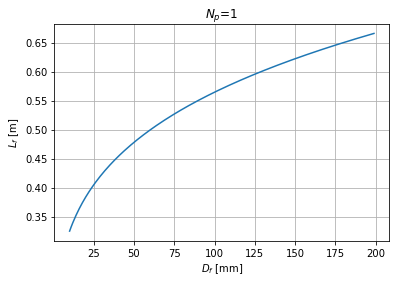

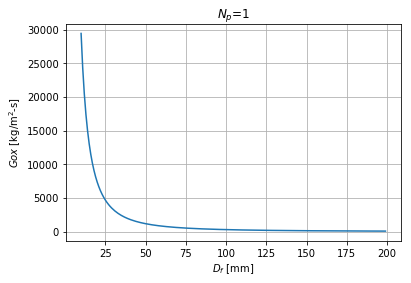

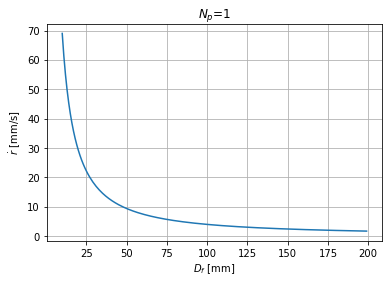

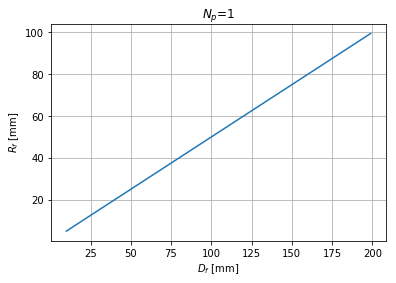

In [16]:
N_p = 1
Df_plotrange = np.arange(10, 200, 1)*1.0e-3

%matplotlib inline
plt.plot(Df_plotrange*1.0e+3, Lf_req(N_p, Df_plotrange))
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$L_f$ [m]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Gox(N_p, Df_plotrange))
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$Gox$ [kg/m$^2$-s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

Gox_plotrange = func_Gox(N_p, Df_plotrange)
plt.plot(Df_plotrange*1.0e+3, func_r(Gox_plotrange)*1.0e+3)
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$\dot r$ [mm/s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Rf(N_p, Df_plotrange)*1.0e+3)
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$R_f$ [mm]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

### $N_p$=4

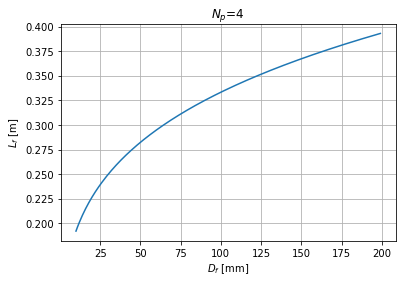

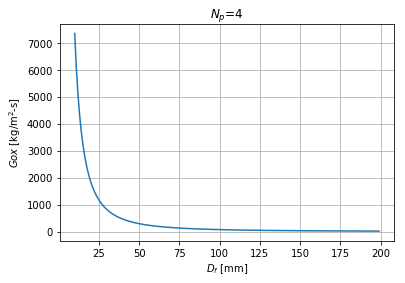

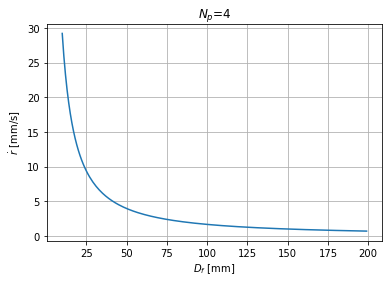

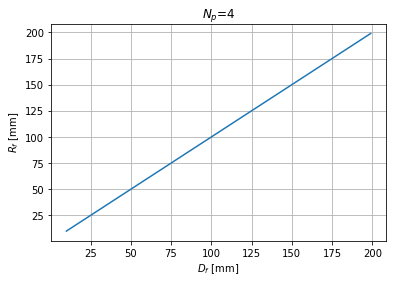

In [17]:
N_p = 4
Df_plotrange = np.arange(10, 200, 1)*1.0e-3

%matplotlib inline
plt.plot(Df_plotrange*1.0e+3, Lf_req(N_p, Df_plotrange))
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$L_f$ [m]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Gox(N_p, Df_plotrange))
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$Gox$ [kg/m$^2$-s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

Gox_plotrange = func_Gox(N_p, Df_plotrange)
plt.plot(Df_plotrange*1.0e+3, func_r(Gox_plotrange)*1.0e+3)
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$\dot r$ [mm/s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Rf(N_p, Df_plotrange)*1.0e+3)
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$R_f$ [mm]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

### $N_p$=6

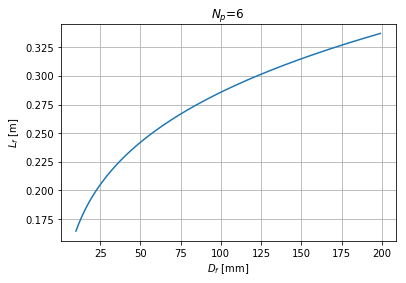

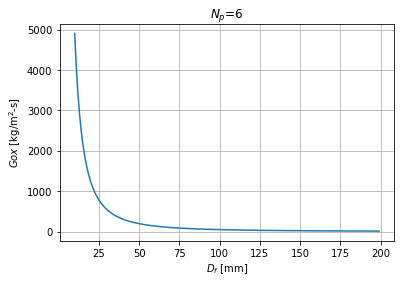

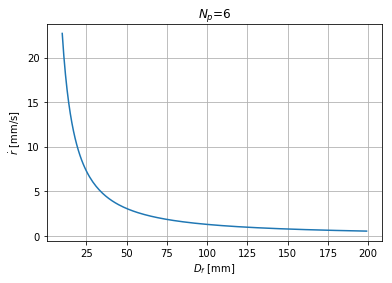

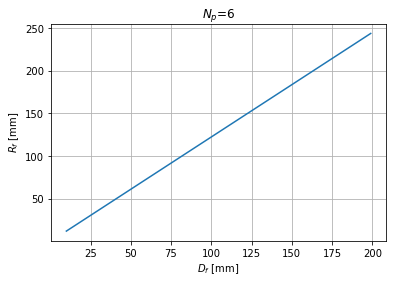

In [18]:
N_p = 6
Df_plotrange = np.arange(10, 200, 1)*1.0e-3

%matplotlib inline
plt.plot(Df_plotrange*1.0e+3, Lf_req(N_p, Df_plotrange))
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$L_f$ [m]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Gox(N_p, Df_plotrange))
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$Gox$ [kg/m$^2$-s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

Gox_plotrange = func_Gox(N_p, Df_plotrange)
plt.plot(Df_plotrange*1.0e+3, func_r(Gox_plotrange)*1.0e+3)
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$\dot r$ [mm/s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Rf(N_p, Df_plotrange)*1.0e+3)
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$R_f$ [mm]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

### $N_p$=8

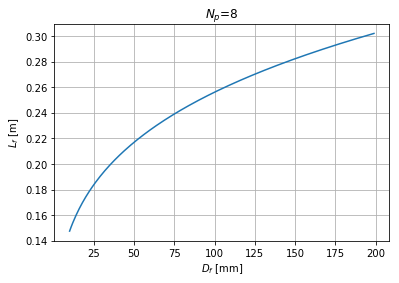

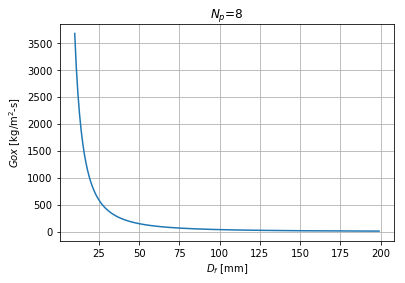

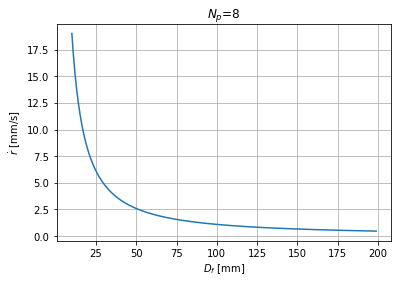

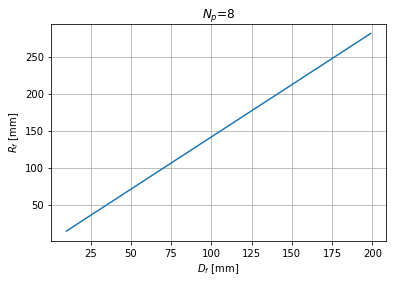

In [19]:
N_p = 8
Df_plotrange = np.arange(10, 200, 1)*1.0e-3

%matplotlib inline
plt.plot(Df_plotrange*1.0e+3, Lf_req(N_p, Df_plotrange))
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$L_f$ [m]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Gox(N_p, Df_plotrange))
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$Gox$ [kg/m$^2$-s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

Gox_plotrange = func_Gox(N_p, Df_plotrange)
plt.plot(Df_plotrange*1.0e+3, func_r(Gox_plotrange)*1.0e+3)
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$\dot r$ [mm/s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Rf(N_p, Df_plotrange)*1.0e+3)
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$R_f$ [mm]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()